# 1. Import modules

In [1]:
import cv2
import math
import numpy as np
import numpy.matlib
import matplotlib.pyplot as plt
import matplotlib.ticker as tick
import os
import random
from datetime import datetime
from PIL import Image
import time
from multiprocessing import Pool
import sys

import scipy 
import scipy.stats
from scipy import ndimage as ndi

from skimage import io
from skimage import data
from skimage.util import img_as_float
from skimage.filters import gabor_kernel
from skimage.filters import gabor

import sklearn
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.externals import joblib
from sklearn.mixture import BayesianGaussianMixture as BGMM
from sklearn.mixture import GaussianMixture
from sklearn import metrics


%matplotlib inline

/home/ubuntu/anaconda3/lib/python3.7/site-packages/sklearn/externals/joblib/__init__.py:15: FutureWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=FutureWarning)


# 2. Define functions

## 2.1. Various functions for computations

In [2]:
def all_feature_xy(I_set,feature_func,*args,thread=4):
    """
    Extract features from each image (Parallel computation available)
    　　　　　
    Parameters
    ----------
    I_set : np.array -> 3d image
    feature_func : str -> filter functions
    args : tuple -> arguments for filter functions
    thread : int -> number of processors for parallel computation
          
    Returns
    ----------
    feature_map : np.array
    """
    
    s = time.time() # To check the computation time
    print(feature_func.__name__,*args)
    
    num_image = I_set.shape[0] # Number of xy images, the value will be 1 for 2d images
    feature_map_stack = []
    
    sample_list = []
    for num in range(num_image):
        sample_list.append((feature_func,I_set[num],*args))
        
    feature_map = np.array(multi_process(sample_list,thread))
    
    print(time.time() - s)
    
    return feature_map


    
def multi_process(sample_list,thread=4):
    """
    Parameters
    ----------
    sample_list : list
    [[func1, args1_1, args1_2],[func2, args2_1, args2_2], ...]
    thread : int
    Number of processors for parallel computing

    Returns
    ----------
    output : list of computation results of each function
    """
    
    p = Pool(thread)
    output = p.map(wrapper, sample_list)
    p.close()
    
    return output

def wrapper(sample_list_each):
    """
    Execute a func in sample_list

    Parameters
    ----------
    sample_list_each : list
    [func, args1, args2, ...]

    Returns
    ----------
    func(*args) : -----
    """
    func = sample_list_each[0]
    hikisuu = sample_list_each[1:]

    return func(*hikisuu)

def all_conv2feat_vec(feat_list):
    """
    Convert feature maps into a vector

    Parameters
    ----------
    feat_list : np.array or list, shape(num_feat, num_image, num_Rows, num_Cols)

    Returns
    ----------
    feat_vec : np.array, shape(num_image X num_Rows X num_Cols, num_feat)
    """
    
    num_image, num_Rows, num_Cols= feat_list[0].shape
    num_Points = num_image * num_Rows * num_Cols
    num_feat = len(feat_list)
    feat_vec = np.zeros((num_Points, num_feat))
    for num in range(num_feat):
        feat_vec[:,num] = feat_list[num].flatten()
            
    return feat_vec

## 2.2. Gabor filters and a Gaussian filter

In [3]:
def gabor_feature(I,frequency,orientation,kyoukai='mirror'):
    """
    Output feature maps with a Gabor filter
    
    Parameters
    ----------
    I : np.array -> 2D image
    frequency (of a Gabor filter, cycles/pixel): float
    orientation (of a Gabor fliter, degree) : float
    kyoukai : int -> boundary condition

    Returns
    ----------
    gabor_map : np.array
    
    """

    g = gabor_kernel(frequency, orientation*np.pi/180)
    gabor_map = np.sqrt(ndi.convolve(I, np.real(g), mode=kyoukai)**2 +
                            ndi.convolve(I, np.imag(g), mode=kyoukai)**2)
    
    return gabor_map


def gaussian_feature(I,sigma):
    """
    Apply Gaussian filter to 2d image
    
    Parameters
    ----------
    I : np.array -> 2d image
    sigma : float -> standard dev of gaussian filter [pixel]

    Returns
    ----------
    gabor_map : np.array
    """
    
    gauss_map = ndi.gaussian_filter(I,sigma)
    
    return gauss_map

def apply_gauss_feat2feat_list(feat_list,sigma,thread=4):
    """
    Parameters
    ----------
    feat_list : np.array or list -> feature map list
    sigma : float -> standard dev of gaussian filter [pixel]
    thread : float -> number of processors

    Returns
    ----------
    gauss_map : np.array -> feature maps after applying Gaussian filters
    """
    
    gauss_map = []
    num_image = feat_list[0].shape[0]
    num_feat = len(feat_list)
    for feat in range(num_feat):
        feat_map = feat_list[feat]
        sample_list = []
        for num in range(num_image):
            sample_list.append((gaussian_feature,feat_map[num],sigma))
        gauss_map.append(np.array(multi_process(sample_list,thread)))
    
    return gauss_map

## 2.3. 1st statistics filters

In [4]:
def mean_feature(I,rad1,rad2,bins):
    """
    Implement convolution with a mean filter
    
    Parameters
    ----------
    I : np.array -> 2d image
    rad_1 : float -> width of the target window
    rad_2 : float -> height of the target window

    Returns
    ----------
    feature_map : np.array
    """
    
    m_image = margin(I,rad1,rad2)
    feature_map = local_feature_1st(m_image,rad1,rad2,bins,local_mean)
    
    return feature_map

def var_feature(I,rad1,rad2,bins):
    """
    Implement convolution with a variance filter
    
    Parameters
    ----------
    I : np.array -> 2d image
    rad_1 : float -> width of the target window
    rad_2 : float -> height of the target window

    Returns
    ----------
    feature_map : np.array
    """
    
    m_image = margin(I,rad1,rad2)
    feature_map = local_feature_1st(m_image,rad1,rad2,bins,local_var)
    
    return  feature_map

def skew_feature(I,rad1,rad2,bins):
    """
    Implement convolution with a skewness filters
    
    Parameters
    ----------
    I : np.array -> 2d image
    rad_1 : float -> width of the target window
    rad_2 : float -> height of the target window

    Returns
    ----------
    feature_map : np.array
    """
    
    m_image = margin(I,rad1,rad2)
    feature_map = local_feature_1st(m_image,rad1,rad2,bins,local_skew)
    
    return feature_map

def kurto_feature(I,rad1,rad2,bins):
    """
    Implement convolution with a kurtosis filter
    
    Parameters
    ----------
    I : np.array -> 2d image
    rad_1 : float -> width of the target window
    rad_2 : float -> height of the target window

    Returns
    ----------
    feature_map : np.array
    """
    
    m_image = margin(I,rad1,rad2)
    feature_map = local_feature_1st(m_image,rad1,rad2,bins,local_kurto)
    
    return feature_map

def energy_feature(I,rad1,rad2,bins):
    """
    Implement convolution with an energy filter

    Parameters
    ----------
    I : np.array -> 2d image
    rad_1 : float -> width of the target window
    rad_2 : float -> height of the target window

    Returns
    ----------
    feature_map : np.array
    """
    
    m_image = margin(I,rad1,rad2)
    feature_map = local_feature_1st(m_image,rad1,rad2,bins,local_energy)
    
    return feature_map

def entropy_feature(I,rad1,rad2,bins):
    """
    Implement convolution with an entropy filter
    
    Parameters
    ----------
    I : np.array -> 2d image
    rad_1 : float -> width of the target window
    rad_2 : float -> height of the target window

    Returns
    ----------
    feature_map : np.array
    """
    
    m_image = margin(I,rad1,rad2)
    feature_map = local_feature_1st(m_image,rad1,rad2,bins,local_entropy)
    
    return feature_map

def margin(I,rad1,rad2):
    """
    Add padding around the image boundary
    
    Parameters
    ----------
    I : np.array -> 2d image
    rad_1 : float -> width of the target window
    rad_2 : float -> height of the target window
               
    Returns
    ----------
    m_image : np.array, shape(I.shape[0] + 2 * rad_1, I.shape[0] + 2 * rad_2)

    """
    
    num_Rows,num_Cols = I.shape
    m_image = np.zeros((num_Rows+2*rad1,num_Cols+2*rad2))
    m_Rows, m_Cols = m_image.shape
    
    m_image[rad1:rad1+num_Rows,rad2:rad2+num_Cols] = I
    
    # top
    m_1 = I[:rad1][::-1]
    m_image[:rad1,rad2:rad2+num_Cols] = m_1
    
    # bottom
    m_2 = I[num_Rows-rad1:][::-1]
    m_image[m_Rows-rad1:,rad2:rad2+num_Cols] = m_2
    
    # left
    m_3 = I[:,:rad2][:,::-1]
    m_image[rad1:rad1+num_Rows,:rad2] = m_3
    
    # right
    m_4 = I[:,num_Cols-rad2:][:,::-1]
    m_image[rad1:rad1+num_Rows,m_Cols-rad2:] = m_4

    # four edges
    m_image[:rad1,:rad2] = I[:rad1,:rad2][::-1,::-1]
    m_image[m_Rows-rad1:,:rad2] = I[num_Rows-rad1:,:rad2][::-1,::-1]
    m_image[:rad1,m_Cols-rad2:] = I[:rad1,num_Cols-rad2:][::-1,::-1]
    m_image[m_Rows-rad1:,m_Cols-rad2:] = I[num_Rows-rad1:,num_Cols-rad2:][::-1,::-1]
    
    return m_image
    
def local_feature_1st(m_image,rad1,rad2,bins,local_feature_func):
    """
    Implement convolution of a 1st statistics filter for 2d image

    Parameters
    ----------
    m_image : np.array -> image with boundary padding
    rad_1 : float -> width of window size
    rad_2 : float -> height of window size
    bins : int -> number of bins of histogram
    local_feature_func : function -> type of 1st statistics filter
    Returns
    ----------
    feature_map : np.array
    """
    
    Rows = m_image.shape[0] - 2 * rad1
    Cols = m_image.shape[1] - 2 * rad2
    feature_map = np.zeros((Rows,Cols))
    for i in range(Rows):
        for j in range(Cols):
            tar = m_image[i:i+2*rad1+1,j:j+2*rad2+1]
            feature_map[i,j] = local_feature_func(tar,bins)
      
    return feature_map

def local_mean(I_local,bins):
    """
    Calculate the mean for the target window

    Parameters
    ----------
    I : np.array -> 2d image
    bins : int -> number of bins of the histogram

    Returns
    ----------
    mean_val : float
    """
    
    hist,b = np.histogram(I_local,bins=bins,range=(0,255))
    #hist_norm = hist / np.mean(hist), original
    hist_norm = hist / np.sum(hist)
    mean_val = np.sum(hist_norm * (b - b[1]*0.5)[1:])
    
    return mean_val

def local_var(I_local,bins):
    """
    Calculate the variance for the target window    

    Parameters
    ----------
    I : np.array -> 2d image
    bins : int -> number of bins of the histogram

    Returns
    ----------
    var_val : float
    """
    
    hist,b = np.histogram(I_local,bins=bins,range=(0,255),normed=True)
    hist_norm = hist / np.sum(hist)
    mu = np.sum(hist_norm * (b - b[1]*0.5)[1:])
    var_val = np.sum(hist_norm * ((b - b[1]*0.5)[1:] - mu) ** 2)
    
    return var_val

def local_skew(I_local,bins):
    """
    Calculate the skewness for the target window    

    Parameters
    ----------
    I : np.array -> 2d image
    bins : int -> number of bins of the histogram

    Returns
    ----------
    skew_val : float
    """
    
    hist,b = np.histogram(I_local,bins=bins,range=(0,255),normed=True)
    hist_norm = hist / np.sum(hist)
    mu = np.sum(hist_norm * (b - b[1]*0.5)[1:])
    sigma = np.sqrt(np.sum(hist_norm * ((b - b[1]*0.5)[1:] - mu) ** 2))
    
    if sigma == 0:
        #print('encounter_zero')
        skew_val = 0
    else:
        skew_val = np.sum(hist_norm * ((b - b[1]*0.5)[1:] - mu) ** 3) / (sigma ** 3)
        
    return skew_val

def local_kurto(I_local,bins):
    """
    Calculate the kurtosis for the target window    

    Parameters
    ----------
    I : np.array -> 2d image
    bins : int -> number of bins of the histogram

    Returns
    ----------
    kurto_val : float
    """
    
    hist,b = np.histogram(I_local,bins=bins,range=(0,255),normed=True)
    hist_norm = hist / np.sum(hist)
    mu = np.sum(hist_norm * (b - b[1]*0.5)[1:])
    sigma = np.sqrt(np.sum(hist_norm * ((b - b[1]*0.5)[1:] - mu) ** 2))
    if sigma == 0:
        #print('encounter_zero')
        kurto_val = -3
    else:
        kurto_val = np.sum(hist_norm * ((b - b[1]*0.5)[1:] - mu) ** 4) / (sigma ** 4) - 3

    return kurto_val

def local_energy(I_local, bins):
    """
    Calculate the energy for the target window    

    Parameters
    ----------
    I : np.array -> 2d image
    bins : int -> number of bins of the histogram

    Returns
    ----------
    ener_val : float
    """
    
    hist,b = np.histogram(I_local,bins=bins,range=(0,255),normed=True)
    hist_norm = hist / np.sum(hist)
    ener_val = np.sum(hist_norm ** 2)
    
    return ener_val

def local_entropy(I_local, bins):
    """
    Calculate the entropy for the target window    

    Parameters
    ----------
    I : np.array -> 2d image
    bins : int -> number of bins of the histogram

    Returns
    ----------
    entr_val : float
    """
    
    hist,b = np.histogram(I_local,bins=bins,range=(0,255),normed=True)
    hist_norm = hist / np.sum(hist)
    ind = (hist_norm >0)
    tar = hist_norm[ind]
    entr_val = - np.sum(tar * np.log2(tar))
    
    return entr_val

# 3. Load input image

List of images:
 ['fig_7a.png', 'fig_6a.jpg', 'fig_9a.png', 'fig_8d_upper.jpg', 'fig_8a_upper.jpg', 'fig_8e_upper.jpg', 'fig_8d_lower.png', 'fig_5c.png', 'fig_8b_upper.jpg', 'fig_5a_copy.jpg', 'fig_8a_lower.png', 'fig_8c_upper.png', '.DS_Store', 'fig_5a_copy_2.jpg', 'fig_7b.png', 'fig_5a.jpg', 'fig_9c.png', 'fig_9d.png', 'fig_8e_lower.png', 'fig_6b.png', 'fig_8b_lower.png', 'fig_8c_lower.png', 'fig_9b.png']

Enter the image filename: fig_8e_upper.jpg

Save folder created at: /home/ubuntu/gabor/result/fig_8e_upper.jpg/210726_0608/

Image shape: (1, 488, 715)


True

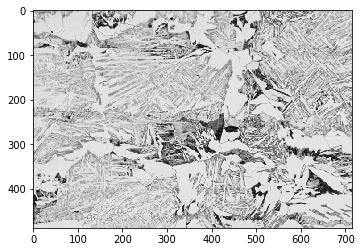

In [5]:
# Change working directory and list available images
'''
Directory order
Working directory
L images_2d, tutorial_2d_github.ipynb (this notebook), result
    L image_1.jpg, ...                                   L image_1.jpg (folder)
                                                             L feat_list_xy.npy
'''

wd = '/home/ubuntu/gabor/' # Change this to your current working directory
os.chdir(wd)
list_img = os.listdir(wd + 'images_2d/') # images folder is located under wd
print('List of images:\n', list_img)


# Load image
filename = input('\nEnter the image filename: ')
im = cv2.imread(wd + 'images_2d/' + filename, 0)

# make directories for saving results
resdir = wd + 'result/' # result directory
os.makedirs(resdir, exist_ok = True)

now = datetime.now()
now_string = now.strftime("%y%m%d_%H%M")
savedir = resdir + filename + '/' + now_string + '/' # save directory
os.makedirs(savedir, exist_ok = True)
print('\nSave folder created at: ' + savedir)

# Convert types of input image
#im = np.array(cv2.imread(workdir + 'images_2d/' + filename, 0))
im = np.array(im)
im = im[np.newaxis,:,:] # convert 2d array to 3d array
im = im.astype(np.float64)
print('\nImage shape:', im.shape)
plt.imshow(im[0], cmap = 'gray')
cv2.imwrite(savedir + 'input_img.png', im[0])

# 4. Settings for various variables and hyperparameters

In [6]:
# Get image size information
num_image, num_Rows, num_Cols = im.shape
num_Points = num_Rows*num_Cols

print('Image information')
print('--image_pixels: {}'.format((num_Rows,num_Cols,num_image)))


# Hyperparameters for Gabor filters
deltatheta = 45 
orientation = np.arange(0,180,deltatheta) # orientations
ori_num = int(len(orientation)) # number of different orientations

lambda_g = np.array([2.0, 3.0, 4.0]) 
frequency_m = 1 / lambda_g # frequencies
f_num = int(len(lambda_g)) # number of different frequencies

xy_step = 0.38
frequency_xy = frequency_m * xy_step ###gabor filterの周波数[cycles / pixel]
g_num = int(f_num * ori_num) # number of different Gabor filters

# Summary of information of Gabor filters
print('\nGabor filters information')
print('--orientations: {}'.format(orientation))
print('--frequencies: {}'.format(frequency_xy))
print('--total numbers of Gabor filters: {}'.format(g_num))

##1st_order_statistics
first_func_list = [mean_feature,var_feature,skew_feature,kurto_feature,energy_feature,entropy_feature] # list of 1st statistics filters
first_func_name = list(map(lambda x: x.__name__,first_func_list)) ###用いる1次統計量名前リスト###
#rad_xy_micro = lambda_g / 2 / xy_step ###xy方向において1次統計量を計算する領域サイズ[µm]
rad_xy_micro = [3, 4, 5]
rad_xy = np.round(rad_xy_micro).astype('uint8') ###xy方向において1次統計量を計算する領域サイズ[pixel]


print('\n1st_order_statistics filters information')
print('--name of filters: {}'.format(first_func_name))
print('--window sizes: {}'.format(rad_xy))

Image information
--image_pixels: (488, 715, 1)

Gabor filters information
--orientations: [  0  45  90 135]
--frequencies: [0.19       0.12666667 0.095     ]
--total numbers of Gabor filters: 12

1st_order_statistics filters information
--name of filters: ['mean_feature', 'var_feature', 'skew_feature', 'kurto_feature', 'energy_feature', 'entropy_feature']
--window sizes: [3 4 5]


# 5. Feature extraction


feat_list_xy.npy is successfully loaded as feat_list

The number of feature maps: 30

feat_list_xy.png is saved at /home/ubuntu/gabor/result/fig_8e_upper.jpg/210726_0608/


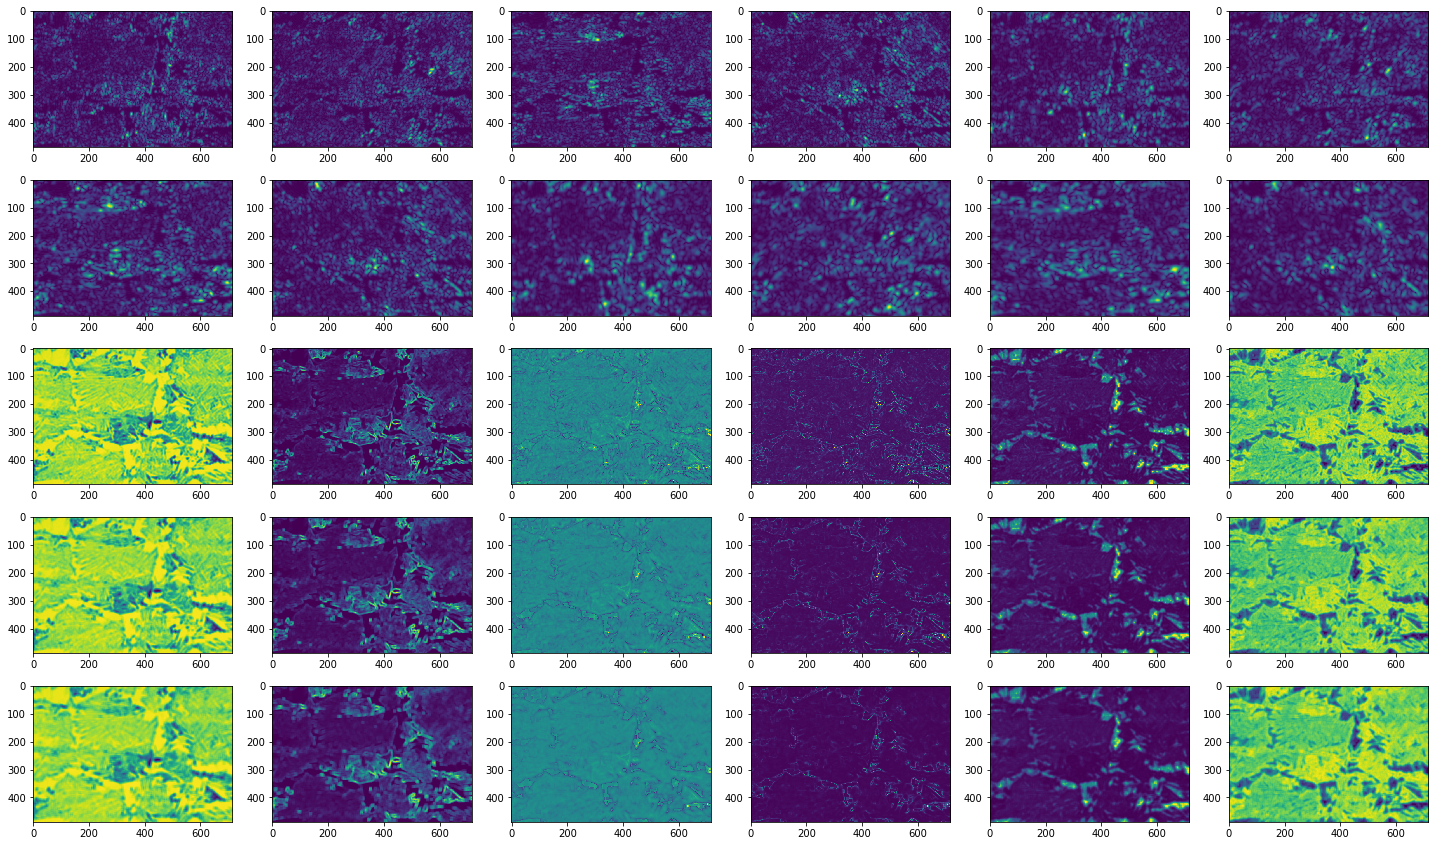

In [7]:
# Extract feature for xy plane image
if not 'feat_list_xy.npy' in os.listdir(resdir + filename):
    feat_func_list = [] 

    # Gabor filters
    for fre in frequency_xy:
        for ori in orientation:
            feat_func_list.append((gabor_feature,fre,ori))


    # 1st order statistics filters
    for rad in  rad_xy:
        for func in first_func_list:
            feat_func_list.append((func,rad,rad,100)) ##rad1,rad2,bins
    
    # Obtain feature maps
    feat_list = [] 
    for num in range(len(feat_func_list)):
        feat_func = feat_func_list[num][0]
        hikisuu = feat_func_list[num][1:]
        feat_list.append(all_feature_xy(im,feat_func,*hikisuu,thread=15))
    

    # Save extracted feature maps
    feat_list = np.array(feat_list)
    np.save(resdir + filename + '/feat_list_xy.npy',feat_list)
    print('\nfeat_list_xy.npy is saved at '+ resdir)

    # Plot feature maps
    fig = plt.figure(figsize = (25,15))
    for i in range(30):
        plt.subplot(5,6,i+1)
        plt.imshow(np.array(feat_list)[i,0])

    plt.savefig(resdir + filename + '/feat_list_xy.png')
    print('\nfeat_list_xy.png is saved at '+ resdir + filename)

#### In Case of loading already saved feature maps...

elif 'feat_list_xy.npy' in os.listdir(resdir + filename):
    feat_list = np.load(resdir + filename +'/feat_list_xy.npy')
    print('\nfeat_list_xy.npy is successfully loaded as feat_list')

    # Index list of feature maps
    gabor = list(range(12))
    mean = [12,18,24] # each corresponds to window size 3,4,5
    var = [13,19,25]
    skew = [14,20,26]
    kurto = [15,21,27]
    energy = [16,22,28]
    entropy = [17,23,29]
    
    # Delete feature maps if necessary
    #feat_list = np.delete(feat_list, var + skew + kurto + entropy, 0)
    #feat_list = np.delete(feat_list, [gabor[i] for i in [0,1,2,3,4,5,6,7,8,9,10,11]] + skew + kurto + energy + entropy, 0)
    
    # Check the number of feature maps after deletion
    print('\nThe number of feature maps: ' + str(feat_list.shape[0]))

    # Plot feature maps
    fig = plt.figure(figsize = (25,15))
    num_feat = feat_list.shape[0]
    for i in range(num_feat):
        plt.subplot(5,6,i+1)
        plt.imshow(np.array(feat_list)[i,0])
    
    # Save feature maps used for the calculation
    plt.savefig(savedir + 'feat_list_xy.png')
    print('\nfeat_list_xy.png is saved at ' + savedir)

Shape of feature maps variable: (348920, 30)
--figure is saved at /home/ubuntu/gabor/result/fig_8e_upper.jpg/210726_0608/explained_var.png
--shape of PC scores data: (348920, 18)


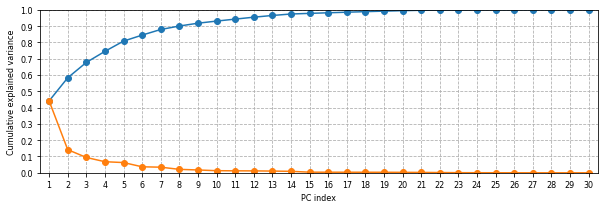

In [9]:
# Smoothing with a Gaussian filter

sigma = 1
feat_list_g = apply_gauss_feat2feat_list(feat_list,sigma)

# Vectorize the feature map
all_feat = feat_list_g
all_feat_backup = all_feat
x_all = all_conv2feat_vec(all_feat) 
x_all_n = scipy.stats.zscore(x_all,axis=0) # Normalization
print("Shape of feature maps variable:", x_all_n.shape)

# PCA
pca = PCA()
pca.fit(x_all_n)
tar = pca.transform(x_all_n)
kiyo = pca.explained_variance_ratio_ # explained variance
loading = pca.components_*np.c_[np.sqrt(pca.explained_variance_)] #各主成分の因子負荷量

kiyo_sum = []
for i in range(len(kiyo)):
    kiyo_sum.append(np.sum(kiyo[:i+1]))

# Visualize the PCA result
num = feat_list.shape[0]
plt.figure(figsize=(10,3)) 
y_1= kiyo_sum[:num]
y_2 = kiyo[:num]
x__ = np.arange(1,num+1)
plt.plot(x__,y_1, marker='o')
plt.plot(x__,y_2, marker='o')
plt.xlim(0.5,num+0.5)
plt.ylim(0,1)
plt.xticks(np.arange(1,num+1))
plt.gca().yaxis.set_major_locator(tick.MultipleLocator(0.1))
plt.rcParams["font.size"] = 8 #グラフのフォントサイズ
plt.grid(linestyle = '--')
plt.xlabel('PC index')
plt.ylabel('Cumulative explained variance')
plt.savefig(savedir + 'explained_var.png')
print('--figure is saved at '+ savedir + 'explained_var.png')

#####主成分数の決定#####
# Use PCs until cumulative explanied variance becomes 0.99
if y_1[1]>0.99:
    x_dim = 2
else:
    x_dim = np.argmax(np.array(y_1) > 0.99)
    
x_pca_hoge = pca.transform(x_all_n)[:,:x_dim]
data = scipy.stats.zscore(x_pca_hoge,axis=0) # Normalization
print('--shape of PC scores data:', data.shape)

# 6. BGMM clustering

In [14]:
#　Define the fraction of datapoints of input image for clustering
"""
Clustering result depends on the fraction and the batch


"""
fraction = 0.15
#np.random.seed(11) 

# Choose datapoints randomly
mabiki = int(data.shape[0]*fraction)
ind = np.random.choice(np.arange(data.shape[0]),mabiki,replace=False)
data_ma = data[ind,:]
data_num = data_ma.shape[0]

# Define the size of the minibatch
batch_frac= 1/100
batch_size = int(data_num *  batch_frac)
batch_num = int(1 / batch_frac)
print("batch_size", batch_frac * fraction * 100, "%", batch_size, 'data')
print("batch_num", batch_num, "batch")

# Begin BGMM training
bgmm_list = []
weight_list = []
min_class = 2
max_class = 10
for num_class in range(min_class, max_class):
    bgmm = BGMM(n_components=num_class,max_iter=10000,
                         tol=1.0e-4,
                         weight_concentration_prior=1,
                         init_params='random',
                         weight_concentration_prior_type = 'dirichlet_distribution',
                         n_init=1,
                         warm_start=True)
    for num in range(int(batch_num)):
        if num == 0:
            bgmm.warm_start = False
        if num == 1:
            bgmm.warm_start = True
        
        target = data_ma[batch_size*num : batch_size*(num+1),:] # Make minibatches
        bgmm.fit(target)
        weight_list.append(list(map(int, bgmm.weight_concentration_)))
        if (num+1) % 10 == 0 : 
            # print numbers of datapoints belong to each class
            print(num_class, 'classes,', num+1,'iters,', list(map(int, bgmm.weight_concentration_)))
    bgmm_list.append(bgmm)
    joblib.dump(bgmm, savedir + 'model_{}.sav'.format(num_class)) # Save models
    bgmm = None
    

batch_size 0.15 % 523 data
batch_num 100 batch
2 classes, 10 iters, [103, 421]
2 classes, 20 iters, [146, 378]
2 classes, 30 iters, [112, 412]
2 classes, 40 iters, [124, 400]
2 classes, 50 iters, [128, 396]
2 classes, 60 iters, [93, 431]
2 classes, 70 iters, [102, 422]
2 classes, 80 iters, [189, 335]
2 classes, 90 iters, [127, 397]
2 classes, 100 iters, [93, 431]
3 classes, 10 iters, [79, 216, 229]
3 classes, 20 iters, [79, 214, 231]
3 classes, 30 iters, [78, 204, 242]
3 classes, 40 iters, [99, 188, 237]
3 classes, 50 iters, [104, 175, 246]
3 classes, 60 iters, [80, 207, 238]
3 classes, 70 iters, [84, 187, 254]
3 classes, 80 iters, [79, 209, 237]
3 classes, 90 iters, [102, 181, 241]
3 classes, 100 iters, [70, 200, 254]
4 classes, 10 iters, [204, 195, 52, 75]
4 classes, 20 iters, [214, 199, 52, 60]
4 classes, 30 iters, [242, 204, 78, 1]
4 classes, 40 iters, [237, 188, 99, 1]
4 classes, 50 iters, [246, 175, 104, 1]
4 classes, 60 iters, [238, 207, 80, 1]
4 classes, 70 iters, [254, 187, 84

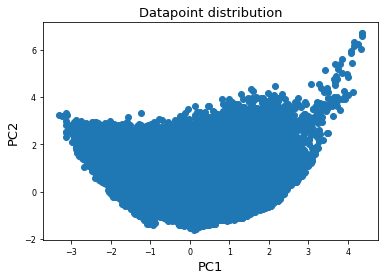

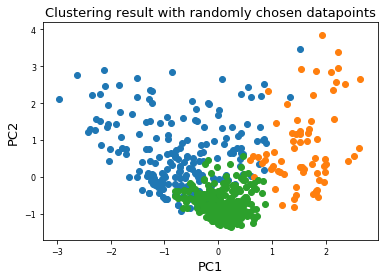

{1, 3, 5}
output_img.png is saved at /home/ubuntu/gabor/result/fig_8e_upper.jpg/210726_0608/output_img.png


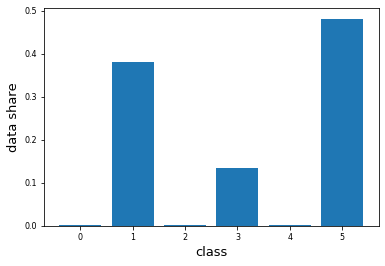

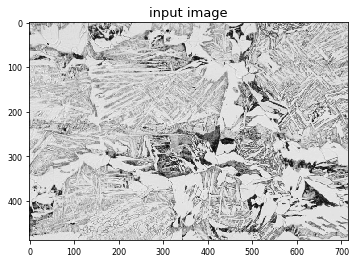

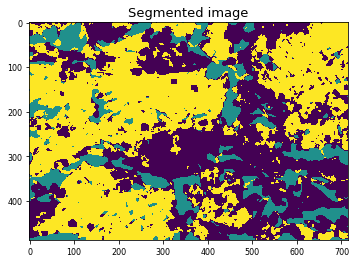

In [16]:
# Plot clustering result
plt.figure()
plt.scatter(data_ma[:,0], data_ma[:,1])
plt.xlabel('PC1', fontsize = 13)
plt.ylabel('PC2', fontsize = 13)
plt.title('Datapoint distribution', fontsize = 13)

#num_clusters = np.argmax(LB_calc_batch_4)
idx = 4
bgmm = bgmm_list[idx]
label_predict = bgmm.predict(target)
label_list = list(set(bgmm.predict(target)))
plt.figure()
for i in label_list:
    label = label_predict == i
    plt.scatter(target[label,0],target[label,1])
    
plt.xlabel('PC1', fontsize = 13)
plt.ylabel('PC2', fontsize = 13)
plt.title('Clustering result with randomly chosen datapoints', fontsize = 13)
plt.show()

# BGMM predict
print(set(bgmm.predict(target)))
weights = bgmm.weights_
components = bgmm.n_components
x_clusters = np.arange(components)
plt.figure()
plt.bar(x_clusters, weights, tick_label=x_clusters)
plt.show
plt.xlabel('class', fontsize = 13)
plt.ylabel('data share', fontsize = 13)

# PREDICT LABELS
image_label = bgmm.predict(data).reshape(num_image,num_Rows,num_Cols)
plt.figure()
plt.imshow(im[0], cmap = 'gray') # input img
plt.title('input image', fontsize = 13)
plt.figure()
plt.imshow(image_label[0]) # output img
plt.title('Segmented image', fontsize = 13)
cv2.imwrite(savedir + 'output_img.png', image_label[0])
image_label = bgmm.predict(data).reshape(num_image,num_Rows,num_Cols)
print('output_img.png is saved at ' + savedir + 'output_img.png')

In [ ]:
image_label.shape

# 7. Color segmented image

In [ ]:
'''
Original segmented image -> 1 x height x width
Color segmented image with RGB values-> 3x height x width 
'''

output_img = cv2.imread(savedir + 'output_img.png', 0)
num_labels = len(np.unique(output_img))
colors = np.random.randint(255, size = (num_labels,3))
#Y = [253,231,36] #RGB
Y = [36,231,253]
#B = [48,103,141] #RGB
B = [141,103,48]
#G = [53,183,120] #RGB
G = [120,183,53]
#D = [68,1,84] #RGB
D = [84,1,68]
#colors = np.array([Y,B,G,D])
colors = np.array([D,G,Y,B])
output_img_colored = np.array([colors[i] for i in output_img[:,:]])
plt.imshow(output_img_colored)
cv2.imwrite(savedir + 'output_img_painted.png', output_img_colored)
print('output_img_painted.png is saved at ' + savedir + 'output_img_painted.png')